## Курсовая работа

Реализация модели для предсказания цен на квартиры.

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 6)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 6)))

    plt.figure(figsize=(18,10))

    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [14]:
class EstatePrice:
    def __init__(self, data):
        self.districts_healthcare = data.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
        self.X_train, self.X_valid, self.y_train, self.y_valid = None, None, None, None  # train sets
        self.feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                             'Ecology_1', 'DistrictSize', 'RoomSquare', 'FloorHeight',
                             'DistrictYear', 'DistrictDensity', 'DistrictPrice', 'Social']
        self.target_name = 'Price'
        self.rf_model, self.gb_model = None, None  # models
        self.rs = 14  # random_state
        
    def fit(self, data):
        # средний год по районам
        self.districts_median_year = data.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        
        # средняя площадь по районам
        self.districts_density = data.groupby(['DistrictId'])['Square'].agg('median').to_dict()
        
        # средняя цена за кв.м. по районам
        self.district_price_per_square = data.groupby(['DistrictId'])['Price'].agg('median')\
                                            / data.groupby(['DistrictId'])['Square'].agg('median')
    
    def preprocessor(self, data):
        # корректируем выбросы и расхождения
        cond = ((data['LifeSquare'] > data['Square']) | data['LifeSquare'].isna())
        data.loc[cond, 'LifeSquare'] = data.loc[cond, 'Square'] * .7
        
        cond = data['KitchenSquare'] > (data['Square'] - data['LifeSquare'])
        data.loc[cond, 'KitchenSquare'] = np.abs(data.loc[cond, 'Square'] - data['LifeSquare']) * .7
        
        # корректируем значения этажей
        data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = 1
        cond = ((data['Floor'] > data['HouseFloor']) & (data['HouseFloor'] > 1))
        data.loc[cond, 'Floor'] = np.random.randint(1, data.loc[cond, 'HouseFloor'])
        cond = ((data['Floor'] > data['HouseFloor']) & (data['HouseFloor'] == 1))
        data.loc[cond, 'Floor'] = 1
        
        # корректируем значения комнат
        data.loc[data['Rooms'] == 0, 'Rooms'] = 1
        cond = (data['Rooms'] > 11)
        data.loc[cond, 'Rooms'] = 1 + data.loc[cond, 'Square'] // 60
        
        # корректируем значения года постройки
        correct_year = {20052011: 2011, 4968: 1968}
        data['HouseYear'] = data['HouseYear'].replace(correct_year)
        
        # "оцифровываем" категориальные признаки
        binary_to_numbers = {'A': 0, 'B': 1}

        data['Ecology_2'] = data['Ecology_2'].replace(binary_to_numbers)
        data['Ecology_3'] = data['Ecology_3'].replace(binary_to_numbers)
        data['Shops_2'] = data['Shops_2'].replace(binary_to_numbers)
        
        data.drop(['Id', 'Healthcare_1'], axis=1, inplace=True)
    
        # добавляем новые признаки
        district_size = data['DistrictId'].value_counts().reset_index()\
                            .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        data = data.merge(district_size, on='DistrictId', how='left')
        data['RoomSquare'] = data['LifeSquare'] / data['Rooms']
        data['FloorHeight'] = data['Floor'] / data['HouseFloor']
        
        # средний возраст района
        data['DistrictYear'] = data['DistrictId'].map(self.districts_median_year)
        data['DistrictYear'].fillna(data['DistrictYear'].median(), inplace=True)

        # средняя площадь квартиры по районам
        data['DistrictDensity'] = data['DistrictId'].map(self.districts_density)
        data['DistrictDensity'].fillna(data['DistrictDensity'].median(), inplace=True)

        # средняя цена за кв.м. по районам
        data['DistrictPrice'] = data['DistrictId'].map(self.district_price_per_square.to_dict())
        data['DistrictPrice'].fillna(data['DistrictPrice'].median(), inplace=True)
        
        scaler = RobustScaler()
        pca = PCA(n_components=1, random_state=self.rs)
        social_scaled = pd.DataFrame(scaler.fit_transform(data[['Social_1', 'Social_2', 'Social_3']]))
        data['Social'] = pca.fit_transform(social_scaled)
        
        return data
    
    def transform(self, data):
        # проводим стандартизацию
        feature_4stand = data[self.feature_names].select_dtypes(include=['float16', 'float32', 'float64']).columns.tolist()
        scaler = StandardScaler()
        stand_features = scaler.fit_transform(data[feature_4stand])
        data[feature_4stand] = pd.DataFrame(stand_features, columns=feature_4stand)
        
        return data
    
    def set_train(self, data):
        # формируем датасеты для обучения
        X = data.drop(columns=self.target_name)
        y = data[self.target_name]
        
        self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.35, 
                                                                                  shuffle=True, random_state=self.rs)

        self.X_train = self.X_train[self.feature_names]
        self.X_valid = self.X_valid[self.feature_names]
    
    def GB_fit(self, learning_rate=0.025, n_estimators=400, max_features=6, max_depth=8, min_samples_leaf=11):
        self.gb_model = GradientBoostingRegressor(
                        learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        max_depth=max_depth, 
                        max_features=max_features, 
                        min_samples_leaf=min_samples_leaf,
                        criterion='mse',
                        random_state=self.rs)
        self.gb_model.fit(self.X_train, self.y_train)
    
    def GB_predict(self, data=None):
        if data is None:
            y_train_preds = self.gb_model.predict(self.X_train)
            y_test_preds = self.gb_model.predict(self.X_valid)
            evaluate_preds(self.y_train, y_train_preds, self.y_valid, y_test_preds)
            return None
        else:
            return self.gb_model.predict(data[self.feature_names])

In [5]:
train_df = pd.read_csv("train.csv")
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [7]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


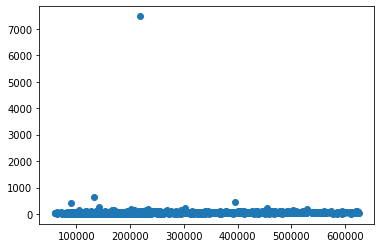

In [8]:
plt.scatter(train_df["Price"], train_df["LifeSquare"])

plt.show()

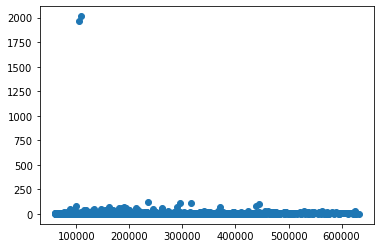

In [9]:
plt.scatter(train_df["Price"], train_df["KitchenSquare"])

plt.show()

In [10]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

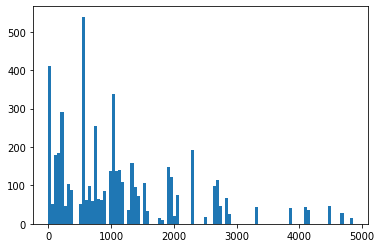

In [11]:
plt.hist(train_df['Healthcare_1'], bins = 100)

plt.show()

На основании информации о датасете необходимо разобраться с пропусками в двух признаках, убрать выбросы в LifeSquare, KitchenSqyare, исправить ошибочные данные в HouseYear и привести в соотвествие этажа и этажности дома.
Добавление новых признаков: медиана для district, средняя площадь комнаты для каждого sample, отношение этажа к этажности

In [15]:
data = train_df.copy()

estatePrice = EstatePrice(data)
estatePrice.fit(data)
data = estatePrice.preprocessor(data)
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,DistrictSize,RoomSquare,FloorHeight,DistrictYear,DistrictDensity,DistrictPrice,Social
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,50.400800,1.889500,56.315775,36.509164,5.536251,7.188800,12.63630,1984.866300,0.118858,0.990300,...,4.231300,0.917500,214138.857399,242.306600,20.823928,0.611892,1978.268400,53.230814,3820.074371,-2.804090e-16
std,43.587592,0.820583,21.058732,17.703530,4.036684,5.103269,6.72767,18.412271,0.119025,0.098015,...,4.806341,0.275139,92872.293865,268.992652,9.740329,0.279636,9.275743,6.065045,988.399108,4.766687e+00
min,0.000000,1.000000,1.136859,0.370619,0.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,...,0.000000,0.000000,59174.778028,1.000000,0.213941,0.041667,1924.500000,33.533077,2109.194622,-1.620569e+00
25%,20.000000,1.000000,41.774881,24.711714,1.000000,3.000000,9.00000,1974.000000,0.017647,1.000000,...,1.000000,1.000000,153872.633942,55.000000,15.777945,0.375000,1975.000000,47.651571,2955.306014,-1.606565e+00
50%,36.000000,2.000000,52.513310,33.279619,6.000000,6.000000,13.00000,1977.000000,0.075424,1.000000,...,3.000000,1.000000,192269.644879,104.000000,19.126276,0.600000,1977.000000,53.949294,3970.074724,-1.210134e+00
75%,75.000000,2.000000,65.900625,45.373475,8.000000,10.000000,17.00000,2001.000000,0.195781,1.000000,...,6.000000,1.000000,249135.462171,511.000000,23.223022,0.875000,1980.000000,56.763182,4410.052962,-6.124105e-01
max,209.000000,10.000000,641.065193,638.163193,58.000000,42.000000,117.00000,2020.000000,0.521867,1.000000,...,23.000000,1.000000,633233.466570,851.000000,319.081597,1.000000,2011.000000,85.591121,8361.390680,2.659215e+01


In [16]:
data = estatePrice.transform(data)
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Shops_1,Shops_2,Price,DistrictSize,RoomSquare,FloorHeight,DistrictYear,DistrictDensity,DistrictPrice,Social
count,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04,1.000000e+04
mean,50.400800,6.207479e-16,-2.330580e-16,-3.941958e-16,4.112613e-16,7.188800,-2.486900e-18,1984.866300,4.450190e-17,0.990300,...,4.231300,0.917500,214138.857399,242.306600,-3.291867e-16,1.521672e-16,7.442466e-15,-1.032552e-15,-4.597572e-16,5.548340e-18
std,43.587592,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,5.103269,1.000050e+00,18.412271,1.000050e+00,0.098015,...,4.806341,0.275139,92872.293865,268.992652,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00,1.000050e+00
min,0.000000,-1.084039e+00,-2.620370e+00,-2.041421e+00,-1.371554e+00,1.000000,-1.729705e+00,1910.000000,-9.986406e-01,0.000000,...,0.000000,0.000000,59174.778028,1.000000,-2.116049e+00,-2.039276e+00,-5.796957e+00,-3.247910e+00,-1.731047e+00,-3.399950e-01
25%,20.000000,-1.084039e+00,-6.905269e-01,-6.664230e-01,-1.123813e+00,3.000000,-5.405262e-01,1974.000000,-8.503701e-01,1.000000,...,1.000000,1.000000,153872.633942,55.000000,-5.180765e-01,-8.471887e-01,-3.523775e-01,-9.199472e-01,-8.749619e-01,-3.370570e-01
50%,36.000000,1.346670e-01,-1.805738e-01,-1.824329e-01,1.148894e-01,6.000000,5.406302e-02,1977.000000,-3.649310e-01,1.000000,...,3.000000,1.000000,192269.644879,104.000000,-1.742997e-01,-4.252962e-02,-1.367506e-01,1.184685e-01,1.517685e-01,-2.538859e-01
75%,75.000000,1.346670e-01,4.551713e-01,5.007337e-01,6.103704e-01,10.000000,6.486522e-01,2001.000000,6.463114e-01,1.000000,...,6.000000,1.000000,249135.462171,511.000000,2.463176e-01,9.409426e-01,1.866898e-01,5.824434e-01,5.969330e-01,-1.284836e-01
max,209.000000,9.884316e+00,2.776894e+01,3.398667e+01,1.299740e+01,42.000000,1.551338e+01,2020.000000,3.386085e+00,1.000000,...,23.000000,1.000000,633233.466570,851.000000,3.062243e+01,1.387975e+00,3.528907e+00,5.335810e+00,4.594848e+00,5.579027e+00


Train R2:	0.91878
Test R2:	0.775218


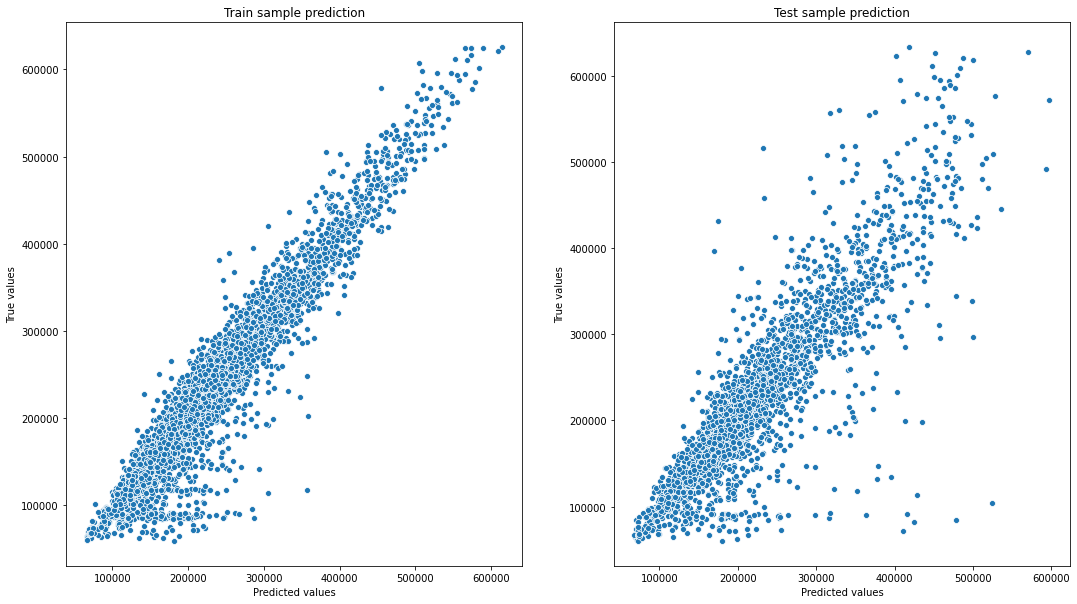

In [17]:
estatePrice.set_train(data)
estatePrice.GB_fit()
estatePrice.GB_predict()

In [18]:
feature_importances_gb = pd.DataFrame(zip(estatePrice.X_train.columns, estatePrice.gb_model.feature_importances_), 
                                   columns=['feature_name_gb', 'importance'])

feature_importances_gb.sort_values(by='importance', ascending=False)

,feature_name_gb,importance
1,Square,0.279317
13,DistrictPrice,0.205334
8,DistrictSize,0.094964
0,Rooms,0.093041
2,LifeSquare,0.092132
14,Social,0.048824
3,KitchenSquare,0.036467
6,HouseYear,0.028362
12,DistrictDensity,0.023527
9,RoomSquare,0.021571


Применяем модель на тестовых данных

In [19]:
test = pd.read_csv('test.csv')
test = estatePrice.preprocessor(test)
test = estatePrice.transform(test)
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,DistrictSize,RoomSquare,FloorHeight,DistrictYear,DistrictDensity,DistrictPrice,Social
0,44,-1.119584,-1.026766,-1.118162,-0.140267,5,-0.538031,1970,-0.697594,1,...,1,1,1,46,-0.175298,-0.236711,-0.140807,-1.032130,0.613947,-0.346628
1,62,-1.119584,-0.731008,-0.431520,1.115057,7,0.648628,2017,-0.397445,1,...,0,0,0,122,1.130201,-0.752221,-0.140807,0.583631,-0.998138,-0.306475
2,27,0.114525,0.157886,0.334237,0.863993,19,0.945292,1977,0.762360,1,...,0,1,1,391,0.035280,1.356684,-0.140807,0.265011,-1.193471,-0.347797
3,23,1.348634,-0.356373,-0.164118,0.110798,2,-1.576357,1965,-0.881250,1,...,0,0,1,264,-1.130839,1.356684,-0.140807,0.130678,-1.768199,-0.348435
4,74,-1.119584,-0.136843,0.080337,-1.144526,8,0.648628,1977,1.579283,1,...,0,6,1,61,2.103386,-0.541330,-0.140807,0.497182,-0.358287,-0.177607


In [20]:
submit = pd.read_csv('sample_submission.csv')
submit['Price'] = estatePrice.GB_predict(test)
submit.head()

,Id,Price
0,4567,154046.003336
1,5925,137250.835330
2,960,143773.660840
3,3848,105444.313793
4,746,181201.579032


In [21]:
submit.to_csv('gb_submit.csv', index=False)